# Latihan-12 Convolutional Stacked Sands

Latihan ini contoh pemodelan 2D model menggunakan external model Vp, Vs, Rho
<br><br> _citation for this page: "Adi Widyantoro, 2021, Pertamina Seismic QI Course, Latihan-12 Convolutional Stacked Sands, accessed MM DD, YYYY."_  
<br>
>(update terakhir tanggal 1 Agustus 2021 oleh Adi Widyantoro)
<hr>

<br> Diperlukan libraries dari: segyio, tqdm dan bruges melalui -pip install-
<br> Juga dependencies: Vpstk1.npy, Vsstk1.npy, dan Rhostk1.npy

    special notes_: terinspirasi oleh program Seismic Forward Modeling yang ditulis oleh Artemii Novoselov
    https://github.com/crimeacs/Seismic_Forward_Modeling

## Tahap-1 Elastic Model Vp, Vs, Rho dari External

In [53]:
# pip install bruges, segio, tqdm

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import segyio
from tqdm import tqdm
import bruges as br
from scipy.signal import hilbert
import scipy as sp
import scipy.ndimage as snd
import copy
import warnings
warnings.filterwarnings("ignore")

In [20]:
# pwd

In [21]:
#   Loading model Vp, Vs, & Rho menggunakan reformatted npy:
Vp = np.load('2Dmodel/Vpstk1.npy')
Vs = np.load('2Dmodel/Vsstk1.npy')
Rho = np.load('2Dmodel/Rhostk1.npy')

In [22]:
#   Loading model Vp, Vs, & Rho menggunakan library segyio (jika menggunakan segy:
# with segyio.open('2Dmodel/stkcha/Vpstk1.sgy', "r", strict=False) as f:
#     Vp = np.stack(t.astype(np.float) for t in f.trace)
# with segyio.open('stkcha/Vsstk1.sgy', "r", strict=False) as f:
#     Vs = np.stack(t.astype(np.float) for t in f.trace)
# with segyio.open('stkcha/Rhostk1.sgy', "r", strict=False) as f:
#     Rho = np.stack(t.astype(np.float) for t in f.trace)

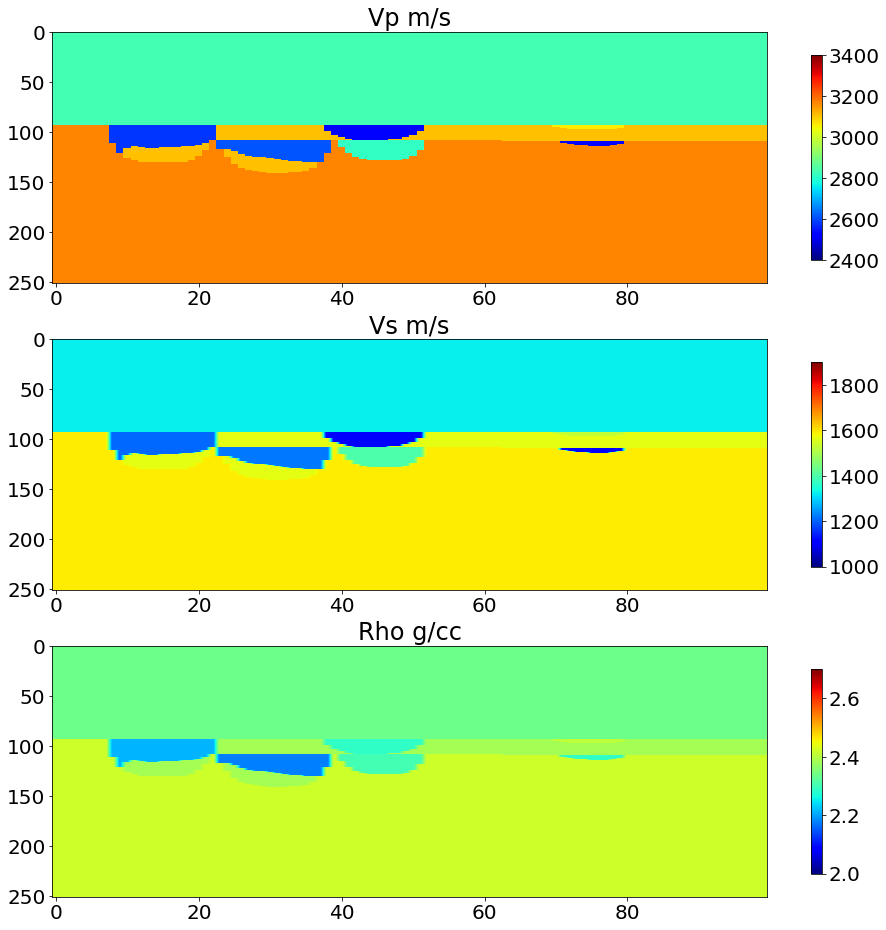

In [23]:
plt.rcParams["font.size"] = "20"
#  Plot dan QC Vp, Vs, Rho
plt.figure(3,figsize=(16, 16))
plt.subplot(311)
plt.imshow(Vp.T, cmap='jet', aspect=.14)
plt.colorbar(shrink=.8); plt.clim(2400,3400) 
plt.title('Vp m/s'); 
plt.subplot(312)
plt.imshow(Vs.T, cmap='jet', aspect=.14)
plt.colorbar(shrink=.8); plt.clim(1000,1900) 
plt.title('Vs m/s')
plt.subplot(313)
plt.imshow(Rho.T, cmap='jet', aspect=.14)
plt.colorbar(shrink=.8); plt.clim(2.0,2.7) 
plt.title('Rho g/cc')
plt.show()

## Add Elastic Property Noise (removes contract boundaries, not recommended)

(251, 100)
(251, 100)


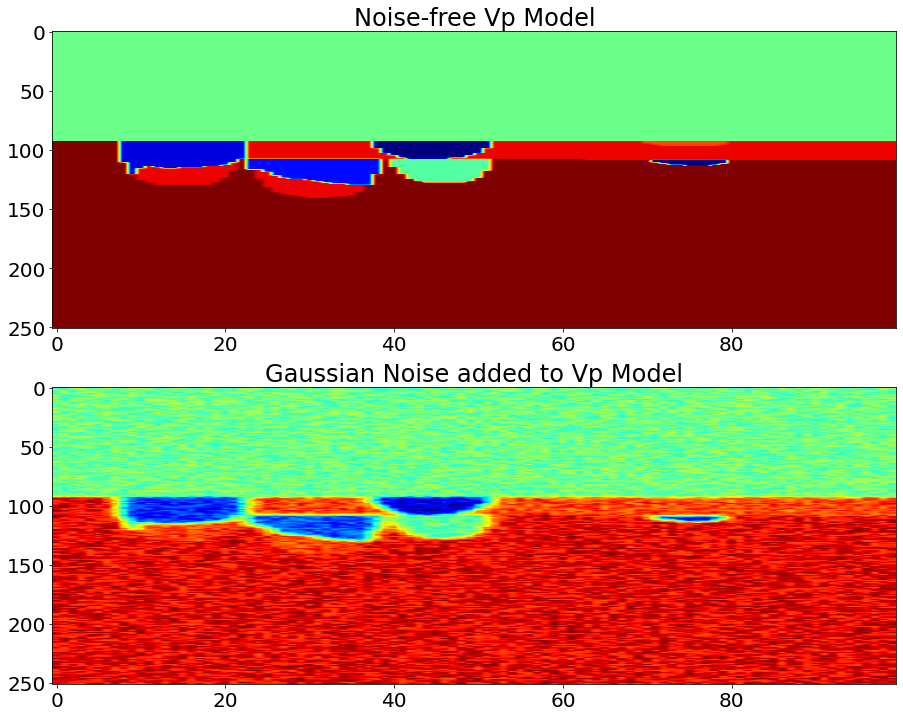

In [6]:
gaussvp = sp.ndimage.gaussian_filter(Vp.T, sigma=1)
noisyVp = gaussvp + 0.8*(gaussvp.std()*np.random.random(gaussvp.shape))
gaussvs = sp.ndimage.gaussian_filter(Vs.T, sigma=1)
noisyVs = gaussvs + 0.8*(gaussvs.std()*np.random.random(gaussvs.shape))
gaussrho = sp.ndimage.gaussian_filter(Rho.T, sigma=1)
noisyRho = gaussrho + 0.8*(gaussrho.std()*np.random.random(gaussrho.shape))
print (np.shape(noisyVp)); print (np.shape(Vp.T))
plt.figure(figsize=(16, 12))
ax1 = plt.subplot(211); ax2 = plt.subplot(212)
ax1.imshow(Vp.T, cmap='jet', aspect=0.14)
ax1.title.set_text('Noise-free Vp Model')
ax2.imshow(noisyVp,cmap='jet', aspect=0.14)
ax2.title.set_text('Gaussian Noise added to Vp Model')
plt.show()

In [7]:
# Pilihan untuk menyimpan model elastic dalam numpy framework:
# np.save(arr=Vp, file='noisyVp.npy')
# np.save(arr=Vs, file='noisyVs.npy')
# np.save(arr=Rho, file='noisyRho.npy')

## Tahap-2 Menghitung Reflection Coefficient

In [8]:
shape = np.shape(Vp)
shape
# menghitung RC
reflectivity = []
for i in tqdm(range(shape[0])):
    vp_t = Vp[i,:]
    vs_t = Vs[i,:]
    rho_t = Rho[i,:]
    gather = br.reflection.reflectivity(vp_t, vs_t, rho_t, theta=range(0,46))
    reflectivity.append(gather)
rc_gathers = np.stack(reflectivity)

100%|███████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.77it/s]


In [9]:
# Pilihan untuk menyimpan gathers dalam numpy framework:
# np.save(arr=rc_gathers, file='rc_gathers.npy')

## Tahap-3 Membuat Synthetic menggunakan wavelet (ricker atau statistics)

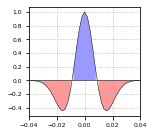

In [10]:
#statistics
# statwavelet = np.genfromtxt('isolatedsands/wavelet.txt')
# w, t = statwavelet[:,1], statwavelet[:,0]
# plt.plot(t, w)
#Ricker
f, l, dt, ph = 25, 400, 2, 0
t = np.arange(-l/2, l/2, dt)/1000
# t = np.linspace(-l/2, (l-dt)/2, int(l/dt))/1000
zerophase = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
h = hilbert (zerophase)
theta = ph*np.pi/180
wavelet = np.cos(theta)*h.real-np.sin(theta)*h.imag
plt.subplots(figsize=(2,2))
plt.plot(t,wavelet,'k', lw=0.5); plt.axhline(0, color='k', lw=0.5)
plt.fill_between(t,wavelet,0, where=wavelet>=0, color='b', alpha=0.4, lw=0); 
plt.fill_between(t,wavelet,0, where=wavelet<0, color='r', alpha=0.4, lw=0); 
plt.grid(True,linestyle=':'); plt.xlim(-0.04,0.04); plt.tick_params(axis='both', which='major', labelsize=6)
plt.show()

In [11]:
# rc_gathers = np.load('stkcha/rc_gathers.npy')
shapeg = rc_gathers.shape
shapeg
def syn(rc, w):
    func = lambda tr: np.convolve(tr, w, mode='same')
    syn = np.apply_along_axis(func, arr=rc, axis=-1)
    return syn.T

syntheticseis = []
for i in tqdm(range(shapeg[0])): 
    convolve = syn(rc_gathers[i,:,:].real, wavelet)
    syntheticseis.append(convolve)
stack = np.stack(syntheticseis)
stack.shape

100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 154.28it/s]


(100, 250, 46)

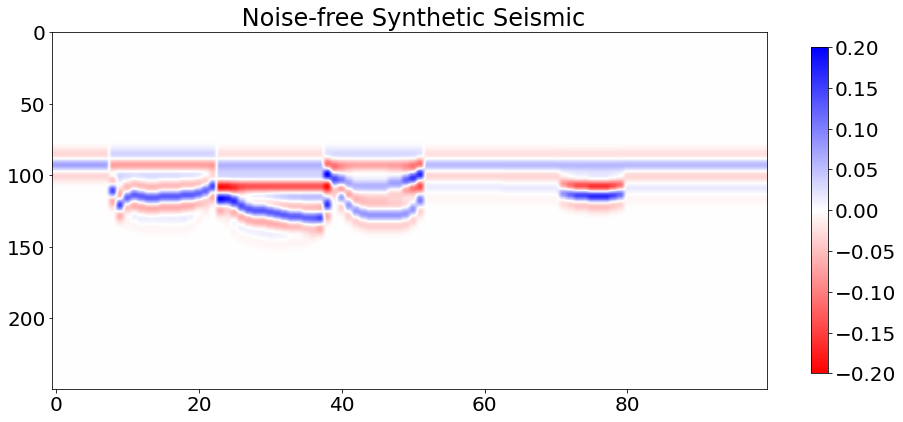

In [12]:
plt.figure(figsize=(16,10))
color=plt.cm.get_cmap('bwr'); colorev=color.reversed()
plt.imshow(stack[:,:,0].T, aspect=.2, cmap=colorev, vmin=-0.2, vmax=0.2)
plt.colorbar(shrink=.6); plt.title(' Noise-free Synthetic Seismic')
plt.show()

In [13]:
# Pilihan untuk menyimpan syn dalam numpy framework:
# np.save(arr=stack, file='stacksyn.npy')

## Add Seismic Noise (seems more appropriate)

(46, 250, 100)
(46, 250, 100)


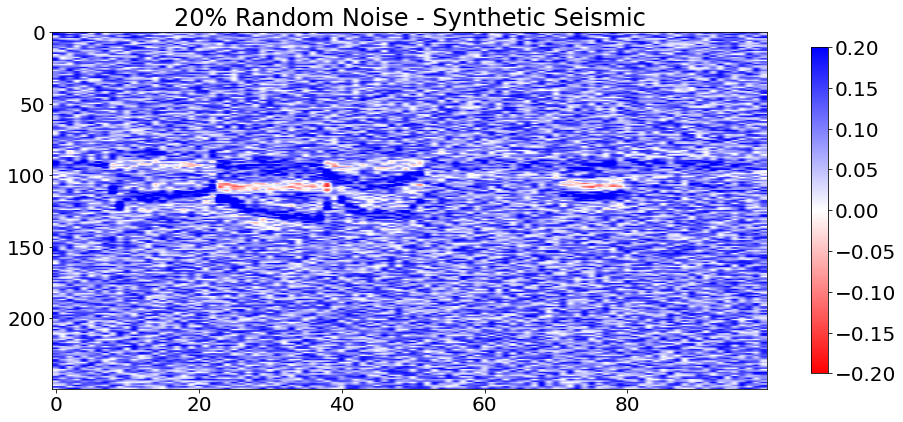

In [14]:
# syn = np.load('stkcha/stacksyn.npy')
snr = sp.ndimage.gaussian_filter(stack, sigma=0.1)
noisysyn = snr + 0.2*(np.random.random(snr.shape))
# noisysyn = snr
print (np.shape(stack.T)); print (np.shape(noisysyn.T))
plt.figure(figsize=(16,10)); color=plt.cm.get_cmap('bwr'); colorev=color.reversed()
plt.imshow(noisysyn[:,:,0].T, aspect=.2, cmap=colorev,vmin=-0.2, vmax=0.2)
plt.colorbar(shrink=.6); plt.title('20% Random Noise - Synthetic Seismic')
plt.show()

## Tahap-4 Membuat Fullstack dan Partial Stack


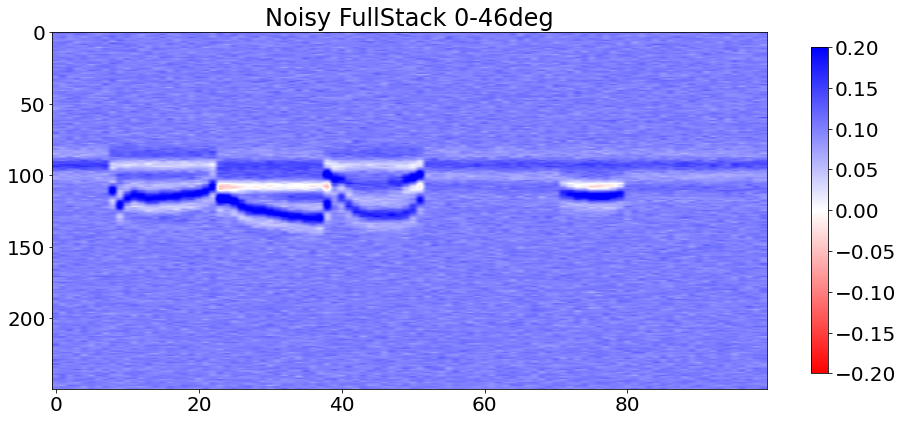

In [15]:
def stack(gathers,min,max):
    sum = gathers[:,:,min:max]
    sum = np.sum(sum, axis=2)
    sum = sum / (max-min)
    return sum

gathers=noisysyn
near = stack(gathers, 5, 15)
mid = stack(gathers, 15, 30)
far = stack(gathers, 30, 45)
fullstk = stack(gathers, 0, 45)
nearminfar=near-far
#near stack plot
plt.figure(figsize=(16, 10)); color=plt.cm.get_cmap('bwr'); colorev=color.reversed()
plt.imshow(fullstk.T, aspect=.2, cmap=colorev, vmin=-0.2, vmax=0.2)
plt.colorbar(shrink=.6);plt.title('Noisy FullStack 0-46deg')
plt.show()

In [16]:
# near and far and near-far

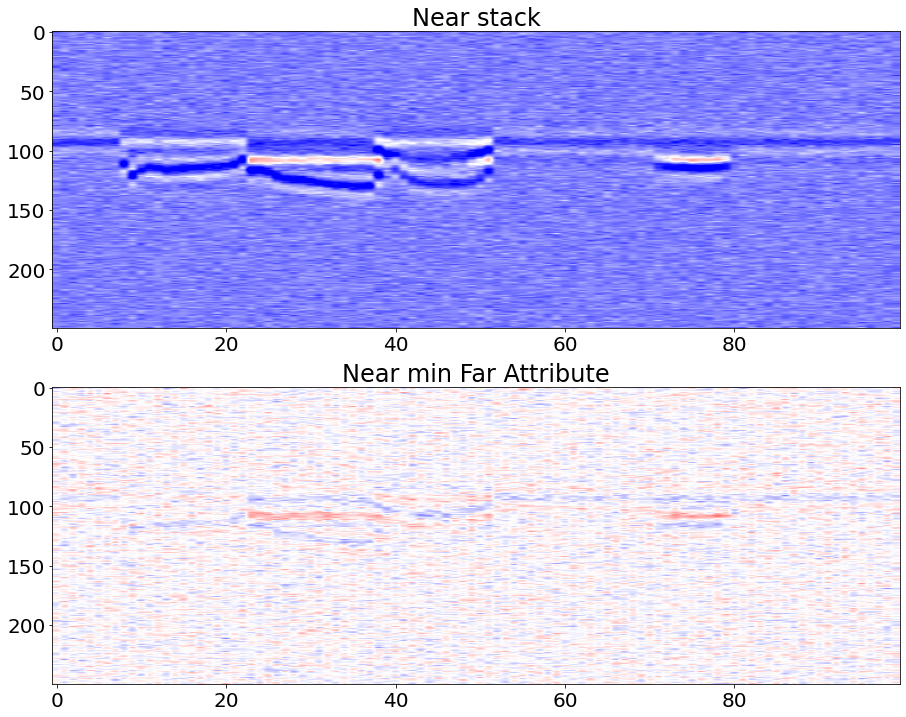

In [17]:
plt.figure(figsize=(16, 12)); color=plt.cm.get_cmap('bwr'); colorev=color.reversed()
ax1 = plt.subplot(211); ax2 = plt.subplot(212)
ax1.imshow(near.T, aspect=.14, cmap=colorev, vmin=-0.2, vmax=0.2)
ax2.imshow(nearminfar.T, aspect=.14, cmap=colorev, vmin=-0.2, vmax=0.2)
ax1.title.set_text('Near stack'); ax2.title.set_text('Near min Far Attribute');
plt.show()

<h1><center>-Akhir Program Latihan-12-<center></h1>